Source: https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

location = "remote"
if location == "remote":
    # TODO: hacky, shouldn't be necessary
    os.environ["WANDB_NOTEBOOK_NAME"] = "lustre_scratch/coralshift/notebooks/transformer.ipynb"
    os.chdir("/lustre_scratch/orlando-code/coralshift/")


In [59]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from sklearn.utils import class_weight
import wandb
from wandb.keras import WandbMetricsLogger
import wandb
from wandb.keras import WandbCallback



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xa
from pathlib import Path
from coralshift.dataloading import bathymetry
from coralshift.machine_learning import baselines
from coralshift.processing import spatial_data
from coralshift.utils import utils
from coralshift.plotting import model_results
from tqdm import tqdm

from coralshift.utils import file_ops, directories

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print(tf.config.experimental.get_visible_devices('GPU'))
    except RuntimeError as e:
        print(e)

!nvidia-smi

2023-06-29 18:12:04.950081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 18:12:06.335444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28946 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB-LS, pci bus id: 0000:85:00.0, compute capability: 7.0


2 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Thu Jun 29 18:12:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.181.07   Driver Version: 418.181.07   CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   30C    P0    41W / 163W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:85:00.0 Off |                    0 |
| N/A   32C    P0    47W / 163W |   2483MiB / 32480MiB |      0%     

# Toy data

In [ ]:
cells = 1280
seq_len = 1000
num_fs = 15
target_frac = 0.1

# N.B. num_samples should eventually represent a single batch
# Creating the features array (num_samples, sequence_length, number of features)
features = np.random.random((cells, seq_len, num_fs)).astype(np.float32)

# Creating the label array (weighted random 1s and 0s, same length as num_samples)
labels = np.random.choice((2), size=(cells,), p=[1-target_frac,target_frac])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Verifying the shape of the arrays
print("Features shape:", features.shape)
print("Label shape:", labels.shape)
print("Class weights:", class_weights)

# send numpy features/label array to tf.Data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((features, labels))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
print("Number of batches:", len(train_dataset))

# Real data

In [ ]:
# TODO: replace with all variables
dir = directories.get_datasets_dir() / "test"
Xs, ys = np.load(dir / "Xs_lstm.npy"), np.load(dir / "ys_lstm.npy")

Xs = np.moveaxis(Xs,1,2)

print("Xs shape: ", Xs.shape)
print("ys shape: ", ys.shape)

limit_to = 20000
# X_train = Xs[:1000, :, :20]
# y_train = ys[:1000]
X_train = Xs[:limit_to]
y_train = ys[:limit_to]

X_test = Xs
y_test = ys



# Better real data

In [5]:
def remove_empty_variables(dataset):
    # Create a mask indicating variables with all zeros, all NaNs, or a mix of zeros and NaNs
    mask = ((dataset == 0) | np.isnan(dataset)).all(dim=['latitude', 'longitude', 'time'])
    
    # Filter out variables based on the mask
    variables = np.array(dataset.data_vars)[~mask.to_array().values]
    dropped_variables = list(set(dataset.data_vars) - set(variables))
    print(f"Variables: {dropped_variables} were removed from the dataset")

    filtered_dataset = dataset.drop_vars(names=dropped_variables)

    return filtered_dataset, dropped_variables


def convert_dataset_to_array(dataset):
    # Convert the dataset to a NumPy array
    array = dataset.to_array().values
    
    # Transpose the dimensions to match the desired shape (latitudes x longitudes x variable_num x time)
    array = np.transpose(array, (1, 2, 0, 3))
    
    return array


def process_xa_ds_ml_ready(
    xa_ds: xa.Dataset,
    feature_vars: list[str] = ["vo", "so", "thetao"],
    gt_var: str = "gt",
    normalise: bool = True,
    onehot: bool = True,
    conv: bool = False):

    # remove any variables which are entirely none/all zero (looking at you sea ice)
    xa_ds, dropped = remove_empty_variables(xa_ds)

    # features array (discarding nans)
    X_array = xa_ds[[feature for feature in feature_vars if feature not in dropped]]
    # gt array
    y_array = xa_ds.isel(time=-1)[gt_var]

    Xs = convert_dataset_to_array(X_array)
    ys = y_array.values

    # naive nan replacement
    ys = spatial_data.naive_nan_replacement(ys)

    if normalise:
        Xs = spatial_data.normalise_3d_array(Xs)

    if onehot:
        Xs = spatial_data.encode_nans_one_hot(Xs)
    Xs = spatial_data.naive_nan_replacement(Xs)
    # fix axes order
    Xs = np.moveaxis(Xs, [0, 1, 2, 3], [3, 0, 2, 1])

    if not conv:
        # if not conv (standard lstm), cast to column
        Xs = spatial_data.spatial_array_to_column(Xs)
        ys = spatial_data.spatial_array_to_column(ys)

    return Xs, ys

In [68]:
train_rows = pd.read_pickle(directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/train.pkl")
test_rows = pd.read_pickle(directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/test.pkl")

train_xa_pp = spatial_data.process_xa_d(train_rows.drop(columns=["onehotnan"]).to_xarray().resample(time="1MS").mean(dim="time"))
test_xa_pp = spatial_data.process_xa_d(test_rows.drop(columns=["onehotnan"]).to_xarray().resample(time="1MS").mean(dim="time"))

In [ ]:
feature_vars = ['bathymetry','ssr','mlotst','bottomT','uo','so','zos','thetao','vo','gradient',]
X_train, y_train = process_xa_ds_ml_ready(train_xa_pp, feature_vars=feature_vars, gt_var="gt")
X_test, y_test = process_xa_ds_ml_ready(test_xa_pp, feature_vars=feature_vars, gt_var="gt")

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

In [ ]:
len(train_rows[train_rows["bathymetry"] == 0])

In [ ]:
len(train_rows[train_rows["bathymetry"] == 0])/len(train_rows)

In [ ]:
lim_test_rows.columns

In [ ]:
train_xa_pp

In [7]:
time_resampled_train_rows = train_xa_pp.to_dataframe()
time_resampled_test_rows = test_xa_pp.to_dataframe()

In [8]:
# drop rows which are entirely nans, onehot encode remaining nans
lim_train_rows = baselines.process_df_for_ml(time_resampled_train_rows[time_resampled_train_rows["bathymetry"] < 0], ignore_vars=[])
lim_test_rows = baselines.process_df_for_ml(time_resampled_test_rows[time_resampled_test_rows["bathymetry"] < 0], ignore_vars=[])

In [9]:
def normalise_df(df: pd.DataFrame) -> pd.DataFrame:
    min_val = df.min().min()
    max_val = df.max().max()

    # Apply min-max scaling while preserving zero values as zero
    normalized_df = (df - min_val) / (max_val - min_val)
    return normalized_df.replace(np.nan, 0)
# normalise 
norm_lim_train_rows = normalise_df(lim_train_rows)
norm_lim_test_rows = normalise_df(lim_test_rows)

In [ ]:
norm_lim_test_rows

In [12]:
def X_y_from_df(df: pd.DataFrame, 
    feature_cols: list[str] = ['bathymetry','ssr','mlotst','bottomT','uo','so','zos','thetao','vo','gradient',], 
    target_col: str = "gt") -> tuple[pd.DataFrame]:
    if not feature_cols:
        feature_cols = [feature for feature in df.columns if feature != target_col]
    return df[feature_cols], df[target_col]

def df_to_linear(df: pd.DataFrame) -> np.ndarray:
    return df.stack().values.reshape(-1, len(df.index.levels[-1]), len(df.columns))

def series_to_linear(series: pd.Series) -> np.ndarray:
    return series.reset_index(drop=True).values.reshape(-1, len(series.index.levels[-1]))

def linear_X_y_from_df(df: pd.DataFrame, feature_cols: list[str] = None, target_col: str = "gt") -> tuple[pd.DataFrame]:
    X, y = X_y_from_df(df, feature_cols=feature_cols, target_col=target_col)
    X_lin, y_lin = df_to_linear(X), series_to_linear(y)
    return np.moveaxis(X_lin, [1,2], [2,1]), y_lin[:,0], y



In [76]:
np.nanmean(train_xa_pp["gt"].isel(time=0).values)

0.033500075

In [82]:
np.nanmean(y_train_lim * 17)

0.03228427

In [87]:
np.max(X_train_lim)

1.0

In [85]:
X_train_lim[:,0,0]

array([0.00190371, 0.00190408, 0.00190466, ..., 0.00190531, 0.00190538,
       0.00190545])

In [ ]:
y_train_lim.reset_index(drop=True).values.reshape(-1, len(y_train_lim.index.levels[-1])).shape

In [ ]:
y_train_lim[:,0].shape

In [ ]:
len(norm_lim_test_rows)

In [14]:
X_train_lim, y_train_lim, train_y_series = linear_X_y_from_df(norm_lim_train_rows.drop(columns=list(set(["spatial_ref"]).intersection(norm_lim_train_rows.columns))))
X_test_lim, y_test_lim, test_y_series = linear_X_y_from_df(norm_lim_test_rows.drop(columns=list(set(["spatial_ref"]).intersection(norm_lim_test_rows.columns))))

print("X_train_lim.shape", X_train_lim.shape)
print("y_train_lim.shape", y_train_lim.shape)
print("X_test_lim.shape", X_test_lim.shape)
print("y_test_lim.shape", y_test_lim.shape)

X_train_lim.shape (13465, 11, 336)
y_train_lim.shape (13465,)
X_test_lim.shape (24973, 11, 336)
y_test_lim.shape (24973,)


In [ ]:
np.nanmax(spatial_data.process_xa_d(y_series.to_xarray()).isel(time=0).values)

In [16]:
train_y_series

latitude    longitude   time      
-18.000000  146.111111  1993-01-01    0.001899
                        1993-02-01    0.001899
                        1993-03-01    0.001899
                        1993-04-01    0.001899
                        1993-05-01    0.001899
                                        ...   
-10.037037  145.962963  2020-08-01    0.001899
                        2020-09-01    0.001899
                        2020-10-01    0.001899
                        2020-11-01    0.001899
                        2020-12-01    0.001899
Name: gt, Length: 4524240, dtype: float32

In [20]:
out_df = train_y_series.reset_index(level="time", drop=True)
out_df.groupby(["latitude", "longitude"]).sum()

latitude    longitude 
-18.000000  146.111111    0.638085
            146.148148    0.638126
            146.185185    0.638090
            146.222222    0.638067
            146.259259    0.638066
                            ...   
-10.037037  145.814815    0.638082
            145.851852    0.638066
            145.888889    0.638066
            145.925926    0.638066
            145.962963    0.638066
Name: gt, Length: 13465, dtype: float32

In [90]:
out_df = test_y_series.reset_index(level="time", drop=True)
grouped_out = out_df.groupby(["latitude", "longitude"]).sum()

In [37]:
out_df

latitude    longitude 
-29.000000  153.481481    0.001861
            153.481481    0.001861
            153.481481    0.001861
            153.481481    0.001861
            153.481481    0.001861
                            ...   
-18.037037  154.000000    0.001861
            154.000000    0.001861
            154.000000    0.001861
            154.000000    0.001861
            154.000000    0.001861
Name: gt, Length: 8390928, dtype: float32

In [25]:
prediction.s

(24973, 1)

In [39]:
pred_df = pd.DataFrame(prediction)

In [40]:
pred_df

,0
0,0.002306
1,0.002310
2,0.002317
3,0.002320
4,0.002304
...,...
24968,0.002332
24969,0.002332
24970,0.002332
24971,0.002331


In [97]:
# Create a new Series with NaN values of length 24973
new_series = pd.Series(np.nan, index=grouped_out.index, name="prediction")

# Assign the values from the array to the appropriate positions in the Series
new_series[:len(prediction)] = prediction.flatten()

concatted = pd.concat([grouped_out, new_series], axis=1)

concatted_xa = concatted.to_xarray()

In [101]:
out_df = train_y_series.reset_index(level="time", drop=True)
grouped_out = out_df.groupby(["latitude", "longitude"]).sum()

# Create a new Series with NaN values of length 24973
new_series = pd.Series(np.nan, index=grouped_out.index, name="prediction")

# Assign the values from the array to the appropriate positions in the Series
new_series[:len(train_prediction)] = train_prediction.flatten()

concatted = pd.concat([grouped_out, new_series], axis=1)

concatted_xa = concatted.to_xarray()

In [48]:
grouped_out

latitude    longitude 
-29.000000  153.481481    0.625302
            153.518519    0.625302
            153.555556    0.625302
            153.592593    0.625302
            153.629630    0.625302
                            ...   
-18.037037  152.444444    0.625302
            152.481481    0.625302
            152.518519    0.625302
            152.555556    0.625302
            154.000000    0.625302
Name: gt, Length: 24973, dtype: float32

In [47]:
new_series

latitude    longitude 
-29.000000  153.481481    0.002306
            153.518519    0.002310
            153.555556    0.002317
            153.592593    0.002320
            153.629630    0.002304
                            ...   
-18.037037  152.444444    0.002332
            152.481481    0.002332
            152.518519    0.002332
            152.555556    0.002331
            154.000000    0.002330
Name: prediction, Length: 24973, dtype: float64

In [45]:
pred_df = pd.concat([grouped_out, new_series], )

In [46]:
pred_df

latitude    longitude 
-29.000000  153.481481    0.625302
            153.518519    0.625302
            153.555556    0.625302
            153.592593    0.625302
            153.629630    0.625302
                            ...   
-18.037037  152.444444    0.002332
            152.481481    0.002332
            152.518519    0.002332
            152.555556    0.002331
            154.000000    0.002330
Length: 49946, dtype: float64

In [ ]:
num_pos = len(lim_test_rows[lim_test_rows["gt"] > 0])
gt_frac = num_pos/len(lim_test_rows)
gt_frac

In [ ]:
feature_vars = ['bathymetry','ssr','mlotst','bottomT','uo','so','zos','thetao','vo','gradient',]
X_train, y_train = process_xa_ds_ml_ready(train_xa_pp, feature_vars=feature_vars, gt_var="gt")
X_test, y_test = process_xa_ds_ml_ready(test_xa_pp, feature_vars=feature_vars, gt_var="gt")

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

In [ ]:
from coralshift.plotting import spatial_plots
spatial_plots.plot_spatial(train_xa_pp["gt"].isel(time=0))

In [95]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

input_shape = X_train_lim.shape[1:]


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    # output_bias=1
):
    # if output_bias is not None:
    #     output_bias = tf.keras.initializers.Constant(output_bias)
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        # x = layers.Dense(dim, activation="relu", bias_initializer=output_bias)(x)
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    # outputs = layers.Dense(N_CLASSES, activation="softmax")(x)
    outputs = layers.Dense(1, activation="sigmoid"
        # , bias_initializer=output_bias
        )(x)

    return keras.Model(inputs, outputs)

wandb.init(
    config = {
        "batch_size": 64,
        "epochs": 100,
        "lr": 0.003755,
        "head_size": 512,
        "num_heads": 2,
        "ff_dim": 4,
        "num_transformer_blocks": 8,
        "mlp_units": 64,
        "mlp_dropout": 0.2,
        "dropout": 0.4
    },
    project="coraltransformer",
)

model = build_model(
    input_shape = X_train_lim.shape[1:],
    head_size=wandb.config.head_size,
    num_heads=wandb.config.num_heads,
    ff_dim=wandb.config.ff_dim,
    num_transformer_blocks=wandb.config.num_transformer_blocks,
    mlp_units=[wandb.config.mlp_units],
    mlp_dropout=wandb.config.mlp_dropout,
    dropout=wandb.config.dropout
    )


# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#     metrics=["sparse_categorical_accuracy"],
# )

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#     loss=keras.losses.BinaryCrossentropy(),
#     # loss="sparse_categorical_crossentropy",
#     metrics=METRICS)

# BEST
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(wandb.config.lr),
    metrics=[keras.metrics.BinaryCrossentropy()],
)

# model.summary()

model.fit(
    X_train_lim,
    y_train_lim*18,
    validation_split=0.2,
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    # callbacks=callbacks,
    callbacks=[WandbMetricsLogger()]

)

wandb.finish()



Epoch 1/100
169/169 [==============================] - 30s 52ms/step - loss: 0.2301 - binary_crossentropy: 0.2301 - val_loss: 0.2800 - val_binary_crossentropy: 0.2800
Epoch 2/100
169/169 [==============================] - 8s 46ms/step - loss: 0.1704 - binary_crossentropy: 0.1704 - val_loss: 0.1932 - val_binary_crossentropy: 0.1932
Epoch 3/100
169/169 [==============================] - 8s 47ms/step - loss: 0.1664 - binary_crossentropy: 0.1664 - val_loss: 0.1491 - val_binary_crossentropy: 0.1491
Epoch 4/100
169/169 [==============================] - 8s 46ms/step - loss: 0.1536 - binary_crossentropy: 0.1536 - val_loss: 0.1567 - val_binary_crossentropy: 0.1567
Epoch 5/100
169/169 [==============================] - 8s 46ms/step - loss: 0.1527 - binary_crossentropy: 0.1527 - val_loss: 0.1566 - val_binary_crossentropy: 0.1566
Epoch 6/100
169/169 [==============================] - 8s 44ms/step - loss: 0.1522 - binary_crossentropy: 0.1522 - val_loss: 0.1622 - val_binary_crossentropy: 0.1622
Epo

epoch/binary_crossentropy,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_binary_crossentropy,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/binary_crossentropy,0.149
epoch/epoch,99
epoch/learning_rate,0.00375
epoch/loss,0.149
epoch/val_binary_crossentropy,0.149


In [96]:
prediction = model.predict(X_test_lim)
print(prediction.shape)
print(prediction)

781/781 [==============================] - 8s 10ms/step
(24973, 1)
[[0.0341763 ]
 [0.03417633]
 [0.03417635]
 ...
 [0.03417888]
 [0.03417888]
 [0.0341789 ]]


In [ ]:
sum(prediction)

In [ ]:

wandb.login()
def main(x=X_train, y=y_train):
    config_defaults = {
        "batch_size": 64,
        "epochs": 5,
        "lr": 0.003755,
        "head_size": 512,
        "num_heads": 2,
        "ff_dim": 4,
        "num_transformer_blocks": 8,
        "mlp_units": 64,
        "mlp_dropout": 0.2,
        "dropout": 0.4
    }
    wandb.init(
        # project="coraltransformer", 
        config=config_defaults)
    config = wandb.config
    
    # Use the config values in your model and training code
    model = build_model(
        input_shape = X_train.shape[1:],
        head_size=wandb.config.head_size,
        num_heads=wandb.config.num_heads,
        ff_dim=wandb.config.ff_dim,
        num_transformer_blocks=wandb.config.num_transformer_blocks,
        mlp_units=[wandb.config.mlp_units],
        mlp_dropout=wandb.config.mlp_dropout,
        dropout=wandb.config.dropout
        )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryCrossentropy()]  # Add your desired metrics here
    )
    
    model.fit(
        x=X_train[:50000],
        y=y_train[:50000],
        validation_split=0.2,
        epochs=wandb.config.epochs,
        batch_size=wandb.config.batch_size,
        # callbacks=callbacks,
        callbacks=[WandbMetricsLogger()],
        workers=0

    )

sweep_configuration = {
    'method': 'random',
    'name': 'first_sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'epoch/binary_crossentropy'
    },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [3]},
        'lr': {'max': 0.1, 'min': 0.0001},
        "head_size": {'values': [256, 512]},
        "num_heads": {'values': [2, 4, 6]},
        "ff_dim": {'values': [2, 4, 6]},
        "num_transformer_blocks": {'min': 2, 'max': 8},
        "mlp_units": {'values': [32, 64, 128]},
        "mlp_dropout": {'values': [0.2, 0.4, 0.6]},
        "dropout": {'values': [0.25, 0.4, 0.5]}
    }
    }

sweep_id = wandb.sweep(sweep_configuration, project="coraltransformer")
count = 10
wandb.agent(sweep_id, count=count, function=main)


In [ ]:
# Find rows where all entries in the first dimension of `array1` are zero
rows_to_remove = np.where(np.all(X_train[:, 0, :] == 0.0, axis=1))[0]

# Remove the corresponding rows from both arrays
filtered_X_train = np.delete(X_train, rows_to_remove, axis=0)
filtered_y_train = np.delete(y_train, rows_to_remove, axis=0)

# Verify the new shapes
print(filtered_X_train.shape)  # Updated shape of X_train
print(filtered_y_train.shape)  # Updated shape of y_train

In [ ]:
rows_to_remove

In [ ]:
# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# limit = 1000

model.fit(
    X_train_lim,
    y_train_lim,
    validation_split=0.2,
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    # callbacks=callbacks,
    callbacks=[WandbMetricsLogger()]

)

wandb.finish()

prediction = model.predict(X_test)
print(prediction.shape)
print(prediction)
# model.evaluate(X_test, y_test, verbose=1)

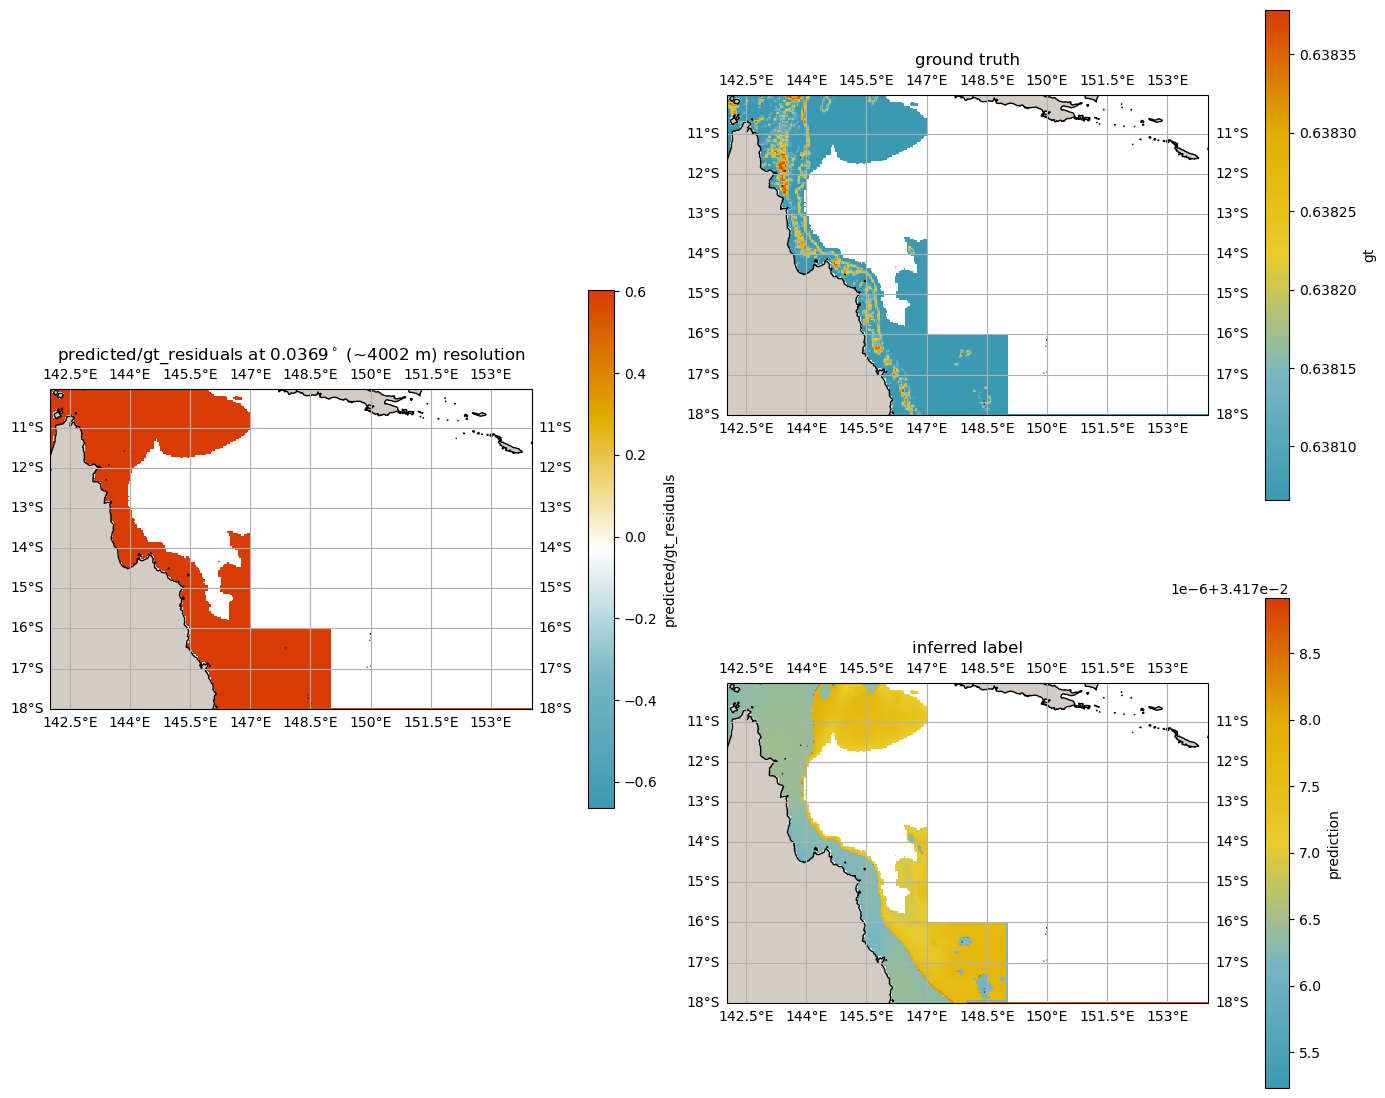

In [102]:
from coralshift.plotting import spatial_plots

confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
        concatted_xa["prediction"], concatted_xa["gt"]
    )
plot_spatial_diffs(concatted_xa["prediction"], concatted_xa["gt"])

In [99]:
train_prediction = model.predict(X_train_lim)
print(train_prediction.shape)
print(train_prediction)

# temp_xa_train = train_xa_pp.copy()

# prediction_xa = spatial_data.process_xa_d(reshape_prediction_into_ds(prediction[:,1], temp_xa))
# binary
# train_prediction_xa = spatial_data.process_xa_d(reshape_prediction_into_ds(train_prediction[:,0], temp_xa_train))

# spatial_plots.plot_spatial(train_prediction_xa["prediction"])


# confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
#         temp_xa_train["prediction"], temp_xa_train["gt"].isel(time=0)
#     )
# plot_spatial_diffs(train_prediction_xa["prediction"], train_prediction_xa["gt"].isel(time=0))


421/421 [==============================] - 4s 10ms/step
(13465, 1)
[[0.03417636]
 [0.03417636]
 [0.03417636]
 ...
 [0.03417702]
 [0.03417697]
 [0.03417695]]


In [ ]:
from coralshift.plotting import spatial_plots

def reshape_prediction_into_ds(numpy_array, ds, newname="prediction"):
    num_lats, num_lons = len(ds["latitude"].values), len(ds["longitude"].values)

    # Reshape the array to have the same dimensions as the dataset
    reshaped_array = np.reshape(numpy_array, (num_lats, num_lons))
    # Convert the reshaped array to an xarray DataArray
    prediction_data = xa.DataArray(data = reshaped_array, 
        coords={"latitude": ds["latitude"], "longitude": ds["longitude"]})
    # Append the new variable to the ds with the label "prediction"
    ds[newname] = prediction_data

    return ds

temp_xa = test_xa_pp.copy()

# prediction_xa = spatial_data.process_xa_d(reshape_prediction_into_ds(prediction[:,1], temp_xa))
# binary
prediction_xa = spatial_data.process_xa_d(reshape_prediction_into_ds(prediction[:,0], temp_xa))

spatial_plots.plot_spatial(prediction_xa["prediction"])

In [61]:
import seaborn as sns
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

def plot_spatial_confusion(
    xa_ds: xa.Dataset, ground_truth_var: str, predicted_var: str, vals_dict: dict, fax = None, cbar_pad = 0.1
) -> xa.Dataset:
    """Plot a spatial confusion matrix based on the predicted and ground truth variables in the xarray dataset.

    Parameters
    ----------
        xa_ds (xarray.Dataset): Input xarray dataset.
        ground_truth_var (str): Name of the ground truth variable in the dataset.
        predicted_var (str): Name of the predicted variable in the dataset.

    Returns
    -------    -------
        xarray.Dataset: Updated xarray dataset with the "comparison" variable added.
    """
    # calculate spatial confusion values and assign to new variable in Dataset
    map_proj = ccrs.PlateCarree()
    if not fax:
        # may need to change this
        fig = plt.figure(figsize=[16,8])
        ax = plt.axes(projection=map_proj)
    else:
        fig = fax[0]
        ax = fax[1]
        
    # from Wes Anderson: https://github.com/karthik/wesanderson/blob/master/R/colors.R
    cmap_colors = ["#EEEEEE", "#3B9AB2", "#78B7C5", "#d83c04", "#E1AF00"]

    im = xa_ds["comparison"].plot.imshow(ax=ax, vmin=0, vmax=4, cmap = mcolors.ListedColormap(cmap_colors))

    spatial_plots.format_spatial_plot(im, fig, ax, title="", name="", cbar=False, edgecolor="black")
    ax.set_aspect("equal")
    # remove old colorbar
    cb = im.colorbar
    cb.remove()

    colorbar = plt.colorbar(im, ax = [ax], location = 'right', pad=cbar_pad)
    num_ticks = len(cmap_colors)
    vmin, vmax = colorbar.vmin, colorbar.vmax
    colorbar.set_ticks([vmin + (vmax - vmin) / num_ticks * (0.5 + i) for i in range(num_ticks)])
    colorbar.set_ticklabels(list(vals_dict.keys()), rotation=0)


def model_output_to_spatial_confusion(label, prediction, lat_lims: tuple[float]=None, lon_lims: tuple[float]=None, fax=None, cbar_pad=0.1) -> None:    
    ds = outputs_to_xa_ds(label, prediction)
    confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
        ds["predictions"], ds["labels"]
    )
    if lat_lims and lon_lims:
        region = {"latitude": slice(min(lat_lims), max(lat_lims)), "longitude": slice(min(lon_lims), max(lon_lims))}
        ds = confusion_values.sel(region)
    ds["comparison"] = confusion_values

    plot_spatial_confusion(ds, "labels", "predictions", vals_dict=vals_dict, fax=fax, cbar_pad=cbar_pad)

def outputs_to_xa_ds(labels, predictions) -> xa.Dataset:
    df = pd.DataFrame({"labels": labels, "predictions": predictions})
    return df.to_xarray().sortby(["longitude", "latitude"])


from coralshift.plotting import model_results


import matplotlib.gridspec as gridspec
def plot_spatial_diffs(
    xa_d_pred: xa.DataArray,
    xa_d_gt: xa.DataArray,
    figsize: tuple[float, float] = (16, 14),
    cbar_pad: float = 0.1
) -> None:
    """
    Plot the spatial differences between predicted and ground truth data.

    Parameters
    ----------
        xa_d_pred (xa.DataArray): Predicted data.
        xa_d_gt (xa.DataArray): Ground truth data.
        figsize (tuple[float, float], optional): Figure size. Default is (16, 9).

    Returns
    -------
        None
    """
    xa_diff = (xa_d_gt - xa_d_pred).rename("predicted/gt_residuals")

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2)

    # left plot
    ax_r = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
    spatial_plots.plot_spatial(fax=(fig, ax_r), xa_da=xa_diff, cmap_type="div", symmetric=True, cbar_pad=cbar_pad)

    # right plots
    ax_l_t = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    spatial_plots.plot_spatial(xa_d_gt, fax=(fig, ax_l_t), title="ground truth", cbar_pad=cbar_pad)
    ax_l_b = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    spatial_plots.plot_spatial(xa_d_pred, fax=(fig, ax_l_b), title="inferred label", cbar_pad=cbar_pad)



confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
        temp_xa["prediction"], temp_xa["gt"].isel(time=0)
    )
plot_spatial_diffs(prediction_xa["prediction"], prediction_xa["gt"].isel(time=0))


NameError: name 'temp_xa' is not defined

In [ ]:
spatial_plots.plot_spatial(processed_test_xa["bathymetry"].isel(time=0).sel({"latitude":slice(-29,-18), "longitude": slice(144,156)}))

In [ ]:
test_xa["prediction"]

In [ ]:
sum(confusion_values)

In [ ]:
test_xa["comparison"] = confusion_values

In [ ]:
sum(test_xa["comparison"])

In [ ]:
test_xa["comparison"].plot()

In [ ]:
plot_spatial_confusion(test_xa, "gt", "prediction", vals_dict=vals_dict)


In [ ]:
(prediction_xa["gt"].isel(time=0).values).flatten()

In [ ]:
prediction_xa

In [ ]:
np.max(prediction)

In [ ]:
prediction_xa["gt"].isel(time=0).values

# Better real data

In [ ]:



def generate_list_net_solars(
    regions: list[str] = ["A", "B", "C", "D"], timesample: str = "1D", 
    chunk_dict: dict={"latitude": 100, "longitude": 100, "time": 100}
    ) -> list[xa.DataArray]:
    era5_dir = directories.get_era5_data_dir()
    era5_list = []
    for region in tqdm(regions, total=len(regions), desc=f" Processing hourly era5 data to '{timesample}' das"):
        region_name = bathymetry.ReefAreas().get_short_filename(region)
        region_net_solar_path = list(
            (era5_dir / f"{region_name}/weather_parameters/").glob("*surface_net_solar_radiation_*.nc"))[0]
        region_dailies = file_ops.open_xa_file(region_net_solar_path)
        era5_list.append(region_dailies.resample(time=timesample).mean(dim="time"))

    return era5_list


def generate_list_gts(regions: list[str] = ["A", "B", "C", "D"], target_resolution_d: float = 1/27, 
    chunk_dict: dict={"latitude": 100, "longitude": 100, "time": 100}
    ) -> list[xa.DataArray]:
    reef_baseline_dir = directories.get_reef_baseline_dir()
    gt_dir = reef_baseline_dir / "gt_files/0-0370d_arrays"

    res_string = utils.generate_resolution_str(target_resolution_d)
    coral_list = []
    for region in tqdm(regions, total=len(regions), desc=f" Loading in reef presence data to das"):
        coral_file = list(gt_dir.glob(f"*{region}*{res_string}*.nc"))[0]
        coral_list.append(file_ops.open_xa_file(coral_file))

    return coral_list


def generate_list_cmems(regions: list[str] = ["A", "B", "C", "D"], 
    chunk_dict: dict={"latitude": 100, "longitude": 100, "time": 100}, period: str="monthly") -> list[xa.Dataset]:

    if period == "monthly":
        cmems_dir = directories.get_monthly_cmems_dir()
    elif period == "daily":
        cmems_dir = directories.get_daily_cmems_dir()
    else:
        raise ValueError(f"Period: {period} not found.")

    filename_search = f"cmems_gopr_{period}_*.nc"

    cmems_list = []
    for region in tqdm(regions, total=len(regions), desc=f" Loading in cmems {period} data to dss"):
        region_name = bathymetry.ReefAreas().get_short_filename(region)
        cmems_file = list((cmems_dir / region_name).glob(filename_search))[0]
        cmems_list.append(file_ops.open_xa_file(cmems_file).isel(depth=0))
        
    return cmems_list


def generate_bath_list(regions: list[str] = ["A", "B", "C", "D"], target_resolution_d: float = 1/27,
    chunk_dict: dict={"latitude": 100, "longitude": 100, "time": 100}) -> list[xa.DataArray]:
    bath_dir = directories.get_bathymetry_datasets_dir()

    res_string = utils.generate_resolution_str(target_resolution_d)

    baths_list = []
    for region in tqdm(regions, total=len(regions), desc=f" Loading in bathymetry data to das"):
        region_name = bathymetry.ReefAreas().get_short_filename(region)
        bath_file = list(bath_dir.glob(f"{region_name}_*{res_string[:3]}*.nc"))[0]
        baths_list.append(file_ops.open_xa_file(bath_file))
        
    return baths_list


def generate_gradients(regions: list[str] = ["A", "B", "C", "D"], target_resolution_d: float = 1/27,
    chunk_dict: dict={"latitude": 100, "longitude": 100, "time": 100}) -> list[xa.DataArray]:
    grads_dir = directories.get_gradients_dir()

    res_string = utils.generate_resolution_str(target_resolution_d)

    grads_list = []
    for region in tqdm(regions, total=len(regions), desc=f" Loading in seafloor gradients data to das"):
        grad_file = list(grads_dir.glob(f"*{region}_{res_string[:5]}*.nc"))[0]
        grads_list.append(file_ops.open_xa_file(grad_file))

    return grads_list


def resample_list_xa_to_target(
    xa_ds_list: list[xa.DataArray | xa.Dataset], target_resolution_d: float = 1/27, lat_lims: tuple[float] = None,
    lon_lims: tuple[float] = None) -> list[xa.DataArray | xa.Dataset]:

    for i, xa_d in tqdm(
        enumerate(xa_ds_list), total=len(xa_ds_list), desc=f" Resampling xa_ds to {target_resolution_d:.04f}"):
        # overwrite present list to save space
        xa_ds_list[i] = spatial_data.resample_xarray_to_target(
            xa_d, target_resolution_d=target_resolution_d, lat_lims=lat_lims, lon_lims=lon_lims)

    return xa_ds_list


def resample_and_save_to_dir(save_dir: Path | str, xa_d, target_resolution_d: float = 1/27, name: str = "eg",
    lat_lims: tuple[float] = None, lon_lims: tuple[float] = None):
    region_list = ["A", "B", "C", "D"]
    save_dir = file_ops.guarantee_existence(save_dir)
    # if list
    if type(xa_d) == list:
        for i, xa_array in tqdm(
            enumerate(xa_d), total=len(xa_d), desc=f" Resampling xa_ds to {target_resolution_d:.04f}"):
            # overwrite present list to save space
            resampled_xa_d = spatial_data.resample_xarray_to_target(
                xa_array, target_resolution_d=target_resolution_d, lat_lims=lat_lims, lon_lims=lon_lims)

            file_ops.save_nc(save_dir, filename=f"{name}_{region_list[i]}", xa_d=resampled_xa_d)
    else:
        resampled_xa_d = spatial_data.resample_xarray_to_target(
                xa_d, target_resolution_d=target_resolution_d, lat_lims=lat_lims, lon_lims=lon_lims)



def get_files_starting_same(dir):
    filepaths = list(dir.glob('*_*'))
    filepaths = [str(filepath) for filepath in filepaths if filepath.is_file()]

    file_dict = {}

    for filepath in filepaths:
        prefix = Path(filepath).stem.split('_')[0]
        if prefix not in file_dict:
            file_dict[prefix] = []
        file_dict[prefix].append(filepath)

    return file_dict


def spatially_combine_dict_ncs_and_save(file_dict, save_dir, resolution_d:float=1/27):

    save_dir = file_ops.guarantee_existence(save_dir)
    for k, v in tqdm(file_dict.items(), desc=" Merging and saving arrays"):
        array_list = []
        for array in v:
            array_list.append(file_ops.open_xa_file(array))

        combined = spatial_data.combine_ds_tiles(array_list, resolution_d=resolution_d)
        file_ops.save_nc(save_dir, k, combined)


# # # bathymetry: resolution *03691*
# bath_xas = generate_bath_list()   # done
# # # cmems monthly (daily later). Split by region, "cmems_gopr_monthly_X.nc"
# cmems_xss = generate_list_cmems() # done
# # # gradients: bathymetry_X_0.03704_gradients.nc
# grad_xas = generate_gradients()
# # # reef presence: gt_files/coral_region_X_1000m_rs_0-0370d.nc
# reef_xas = generate_list_gts()    # done
# # # era5
# era5_xas = generate_list_net_solars(timesample="1M") # done

# called with each list above
resample_and_save_to_dir(save_dir=directories.get_datasets_dir() / "monthly_0-037_arrays", xa_d=reef_xas, name="coral")

In [ ]:
# xa.open_dataset(directories.get_datasets_dir() / "monthly_0-037_arrays/coral_D.nc")["coral_region_D_1000m_0-0370d"].plot()

# xa_d = file_ops.open_xa_file(directories.get_reef_baseline_dir() / "gt_files")
# resampled = spatial_data.resample_xarray_to_target()

# xa.open_dataset(directories.get_reef_baseline_dir() / "gt_files/coral_region_B_1000m.nc")["coral_region_B_1000m"].plot()

# file_dict = get_files_starting_same(directories.get_datasets_dir() / "monthly_0-037_arrays")
# spatially_combine_dict_ncs_and_save(file_dict, directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined")

## Load in nc files and cleverly cast to dfs. Either automate or hide.

In [ ]:
bathymetry_data = xa.open_dataset(
    directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/bathymetry.nc").rename({"blank": "bathymetry"})


# splitting spatially, training on North
bath_df = baselines.xa_dss_to_df([bathymetry_data])[0]
train_coords_list, test_coords_list = baselines.generate_test_train_coords_from_dfs(
    [bath_df], split_type="spatial", train_test_lat_divide=-18)

In [ ]:
cmems_all = xa.open_dataset(
    directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/cmems.nc")

coral_all = xa.open_dataset(
    directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/coral.nc").rename({"coral_region_B_1000m_0-0370d": "gt"})
coral_df = baselines.xa_dss_to_df([coral_all], bath_mask=False)[0]
solar_all = xa.open_dataset(
    directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/solar.nc")

gradients_all = xa.open_dataset(
    directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/gradients.nc").rename({"__xarray_dataarray_variable__": "gradient"})
grads_df = baselines.xa_dss_to_df([gradients_all], bath_mask=False)[0]

In [ ]:
# dummy_xa = spatial_data.generate_dummy_xa(target_1/27, lat_lims=(-29,-10), lon_lims=(142, 156))
target_resolution_d = 1/27
for i, array in enumerate([cmems_all, coral_all, solar_all, gradients_all, bathymetry_data]):
    if i == 0:
        cmems_all_rs = spatial_data.resample_xarray_to_target(cmems_all.rio.write_crs("EPSG:4326"), target_resolution_d=target_resolution_d,
            lat_lims=(-29,-10), lon_lims=(142, 156))
    if i == 1:
        coral_all_rs = spatial_data.resample_xarray_to_target(coral_all.rio.write_crs("EPSG:4326"), target_resolution_d=target_resolution_d,
            lat_lims=(-29,-10), lon_lims=(142, 156))
    if i == 2:
        solar_all_rs = spatial_data.resample_xarray_to_target(solar_all.rio.write_crs("EPSG:4326"), target_resolution_d=target_resolution_d,
            lat_lims=(-29,-10), lon_lims=(142, 156))
    if i == 3:
        grads_all_rs = spatial_data.resample_xarray_to_target(gradients_all.rio.write_crs("EPSG:4326"), target_resolution_d=target_resolution_d,
            lat_lims=(-29,-10), lon_lims=(142, 156))
    if i == 4:
        baths_all_rs = spatial_data.resample_xarray_to_target(bathymetry_data.rio.write_crs("EPSG:4326"), target_resolution_d=target_resolution_d,
            lat_lims=(-29,-10), lon_lims=(142, 156))


In [ ]:
solar_all_rs.resample(time="1MS").mean(dim="time")

In [ ]:
# cmems_all_rs["bottomT"].isel(time=0).plot()
# solar_all_rs["ssr"].isel(time=0).plot()
coral_all_rs["gt"].plot()

In [ ]:
(solar_bath_xa,) = xa.broadcast(xa.merge([baths_all_rs, solar_all_rs]))

In [ ]:
solar_bath_df = baselines.xa_dss_to_df([solar_bath_xa], bath_mask=True)[0]
# solar_bath_df.head()

In [ ]:
cmems_df = baselines.xa_dss_to_df([cmems_all_rs], bath_mask=False)[0]

In [ ]:
# merge by matching coordinates
solar_bath_cmems_df = cmems_df.join(solar_bath_df.drop(columns=["latitude","longitude","onehotnan"]), how="outer")

In [ ]:
np.nansum(solar_bath_cmems_df["vo"])

In [ ]:
grads_df = baselines.xa_dss_to_df([grads_all_rs], bath_mask=False)[0]
solar_bath_cmems_grads_df = solar_bath_cmems_df.join(grads_df.drop(columns=["latitude","longitude","onehotnan"]))

In [ ]:
np.nansum(solar_bath_cmems_grads_df["ssr"])

In [ ]:
coral_df = baselines.xa_dss_to_df([coral_all_rs], bath_mask=False)[0]

all_df = solar_bath_cmems_grads_df.join(coral_df.drop(columns=["latitude","longitude","onehotnan"]))
all_df.head(10)

In [ ]:
all_df.iloc[:100].groupby(level=["time"]).mean()

In [ ]:
print("ssr",np.nansum(all_df["ssr"]))
print("gt",np.nansum(all_df["gt"]))
print("bathymetry",np.nansum(all_df["bathymetry"]))
print("gradient",np.nansum(all_df["gradient"]))

## Writing files here

In [ ]:
all_df.to_pickle(directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/all.pkl")

In [ ]:
processed_df = baselines.process_df_for_ml(all_df, ignore_vars=["latitude", "longitude", "onehotnan"])
# processed_df.head(10)

In [ ]:
train_rows = processed_df.loc[processed_df.index.get_level_values('latitude') > -18]
test_rows = processed_df.loc[processed_df.index.get_level_values('latitude') < -18]

train_rows.to_pickle(directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/train.pkl")
test_rows.to_pickle(directories.get_datasets_dir() / "monthly_0-037_arrays/spatially_combined/test.pkl")